# Super Resolution Convolutional Neural Networks (SRCNN)

This notebook aims to reproduce the work of Dong et. al (2015) with the DIV2K dataset.

Link to their arXiv paper:

[Image Super-Resolution Using Deep Convolutional Networks](https://arxiv.org/abs/1501.00092)

Link to DIV2K dataset:

[DIV2K dataset: DIVerse 2K resolution high quality images](https://data.vision.ee.ethz.ch/cvl/DIV2K/)

# 1 Import Libraries

In [1]:
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader

import torch
import cv2
import numpy as np
import torchvision.transforms.v2 as transforms

from torch.optim import SGD

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from tqdm import tqdm
from datetime import datetime

cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

True

# 2 Model Architecture

In [2]:
class SRCNN(torch.nn.Module):
    def __init__(self, num_channels=1, num_filters=(64, 32), kernel_sizes=(9, 1, 5)):
        super(SRCNN, self).__init__()

        self.convs = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels, num_filters[0], kernel_size=kernel_sizes[0]),
            torch.nn.ReLU(inplace=False)
        )

        for i in range(len(num_filters) - 1):
            self.convs.append(torch.nn.Conv2d(num_filters[i], num_filters[i + 1], kernel_size=kernel_sizes[i + 1]))
            self.convs.append(torch.nn.ReLU(inplace=False))

        self.convs.append(torch.nn.Conv2d(num_filters[-1], num_channels, kernel_size=kernel_sizes[-1]))
        self.convs.append(torch.nn.ReLU(inplace=False))

        self.initialize_weights()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, torch.nn.Conv2d):
                torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)
                torch.nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Output is shrinked by sum(kernel_sizes) - len(kernel_sizes) due to zero padding
        return self.convs(x)

# 3 Dataset Definition

The following configurations are used:

- Sub-images size: 33 x 33
- Stride: 14
- Scaling factor: 3

In [3]:
class SRCNNTrainingDataset(Dataset):
    def __init__(self, img_dir, sub_img_size=33, stride=14, scale=3, subset=None):
        super(SRCNNTrainingDataset, self).__init__()

        self.img_dir = img_dir
        self.sub_img_size = sub_img_size
        self.stride = stride
        self.scale = scale

        imgs_path = glob(os.path.join(img_dir, '*.png'))

        if subset is not None:
            if isinstance(subset, int):
                imgs_path = imgs_path[:subset]
            elif isinstance(subset, float):
                imgs_path = imgs_path[:int(len(imgs_path) * subset)]

        self.imgs = [cv2.imread(path, cv2.IMREAD_COLOR_RGB) for path in imgs_path]

        img_patches_count = []
        sub_imgs_count = 0

        bar = tqdm(imgs_path, desc='Calculating image patches count')
        
        for path in bar:
            img = cv2.imread(path, cv2.IMREAD_COLOR_RGB)
            
            # Ensure the image is divisible by the scale factor
            h, w, _ = img.shape
            img = img[:h - (h % scale), :w - (w % scale), :]

            h, w, _ = img.shape

            h_count = (h - sub_img_size) // stride + 1
            w_count = (w - sub_img_size) // stride + 1
            sub_imgs_count += h_count * w_count

            img_patches_count.append((sub_imgs_count, h_count, w_count))

        self.img_patches_count = img_patches_count

        self.transform_hr = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])

        # Create low-resolutioin image by downscaling and blurring
        self.transform_lr = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(scale * 2 + 1, scale * 2 + 1), sigma=1),
            transforms.Resize((sub_img_size // scale, sub_img_size // scale), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Resize((sub_img_size, sub_img_size), interpolation=transforms.InterpolationMode.BICUBIC)
        ])

    def __len__(self):
        return self.img_patches_count[-1][0]
    
    def __getitem__(self, idx):
        img_idx = 0

        while idx >= self.img_patches_count[img_idx][0]:
            img_idx += 1

        w_count = self.img_patches_count[img_idx][2]
        excess = idx - self.img_patches_count[img_idx - 1][0] if img_idx > 0 else idx
        idx_h = excess // w_count
        idx_w = excess % w_count

        img = self.imgs[img_idx]

        # img = cv2.imread(os.path.join(self.img_dir, str.zfill(str(img_idx + 1), 4) + '.png'), cv2.IMREAD_COLOR_RGB)

        patch = img[
            idx_h * self.stride:idx_h * self.stride + self.sub_img_size,
            idx_w * self.stride:idx_w * self.stride + self.sub_img_size,
            :
        ]

        hr = self.transform_hr(patch)
        lr = self.transform_lr(hr)

        return lr, hr
    
class SRCNNValidationDataset(Dataset):
    def __init__(self, img_dir, scale=3, subset=None):
        super(SRCNNValidationDataset, self).__init__()

        self.img_dir = img_dir
        self.scale = scale
        self.imgs_path = glob(os.path.join(img_dir, '*.png'))

        if subset is not None:
            if isinstance(subset, int):
                self.imgs_path = self.imgs_path[:subset]
            elif isinstance(subset, float):
                self.imgs_path = self.imgs_path[:int(len(self.imgs_path) * subset)]

        self.transform_hr = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.imgs_path)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.imgs_path[idx], cv2.IMREAD_COLOR_RGB)

        # Ensure the image is divisible by the scale factor
        h, w, _ = img.shape
        img = img[:h - (h % self.scale), :w - (w % self.scale), :]

        hr = self.transform_hr(img)

        # Create low-resolutioin image by downscaling and blurring
        transform_lr = transforms.Compose([
            transforms.GaussianBlur(kernel_size=(self.scale * 2 + 1, self.scale * 2 + 1), sigma=1),
            transforms.Resize((hr.shape[1] // self.scale, hr.shape[2] // self.scale), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Resize((hr.shape[1], hr.shape[2]), interpolation=transforms.InterpolationMode.BICUBIC)
        ])

        lr = transform_lr(hr).squeeze(0)
        
        return lr, hr

Calculating image patches count: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


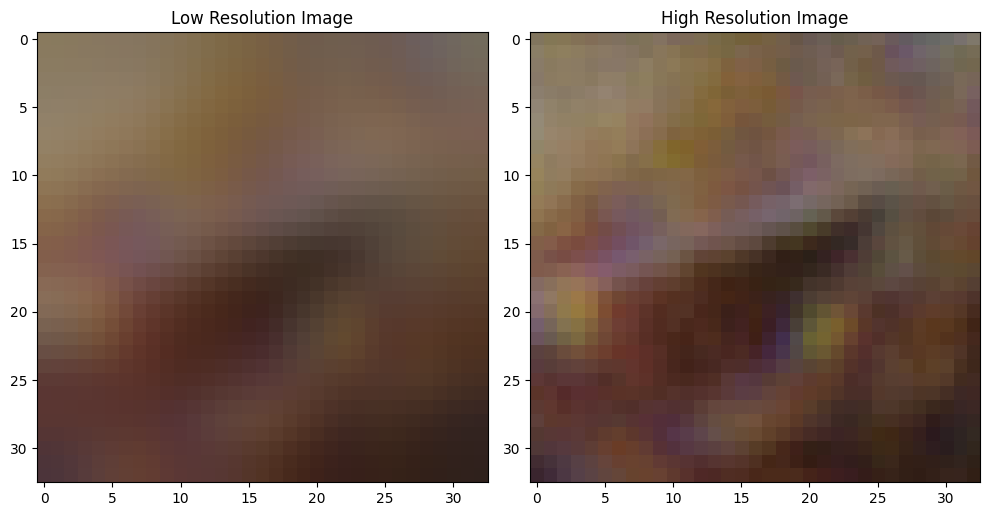

In [4]:
sample_dataset = SRCNNTrainingDataset(
    img_dir=r'../data/DIV2K_train_HR',
    sub_img_size=33,
    stride=14,
    scale=3,
    subset=1
)
idx = np.random.randint(0, len(sample_dataset))

sample_lr, sample_hr = sample_dataset[idx]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow(sample_hr.permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')

plt.tight_layout()
plt.show()

# 4 Training

In [5]:
batch_size = 128

train_dataset = SRCNNTrainingDataset(img_dir=r'../data/DIV2K_train_HR', sub_img_size=33, stride=14, scale=3, subset=2)
set5_val_dataset = SRCNNValidationDataset(img_dir=r'../data/Set5', scale=3)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_set5_loader = DataLoader(set5_val_dataset, batch_size=1, shuffle=False)

srcnn_9_1_5 = SRCNN(num_channels=3, num_filters=(64, 32), kernel_sizes=(9, 1, 5)).to(cuda_device)

srcnn_9_1_5_optim = SGD(
    [
        {'params': srcnn_9_1_5.convs[0].parameters(), 'lr': 1e-5},
        {'params': srcnn_9_1_5.convs[1].parameters(), 'lr': 1e-5},
        {'params': srcnn_9_1_5.convs[2].parameters(), 'lr': 1e-6},
    ],
    momentum=0.9
)

mse_loss = torch.nn.MSELoss(reduction='mean')

Calculating image patches count: 100%|██████████| 2/2 [00:00<00:00, 22.34it/s]


In [ ]:
epochs = 3

writer = SummaryWriter(log_dir='../runs/srcnn_9_1_5')

for epoch in range(epochs):
    srcnn_9_1_5.train()
    train_loss = 0.0

    bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

    best_model = None

    for lr, hr in bar:
        lr = lr.to(cuda_device, non_blocking=True)
        hr = hr.to(cuda_device, non_blocking=True)

        srcnn_9_1_5_optim.zero_grad()

        sr = srcnn_9_1_5(lr)
        # sr = sr.clamp(0.0, 1.0)

        _, _, h, w = sr.shape
        hr_cropped = transforms.CenterCrop([h, w])(hr)

        loss = mse_loss(sr, hr_cropped)

        loss.backward()
        srcnn_9_1_5_optim.step()

        train_loss += loss.item() * lr.size(0)

        bar.set_postfix({'loss': loss.item()})

    train_loss /= len(train_loader.dataset)
    writer.add_scalar('Loss/train', train_loss, epoch)

    # Validation on Set5
    srcnn_9_1_5.eval()
    set5_psnr = 0.0

    with torch.no_grad():
        for lr, hr in val_set5_loader:
            lr = lr.to(cuda_device)
            hr = hr.to(cuda_device)

            sr = srcnn_9_1_5(lr)
            # sr = sr.clamp(0.0, 1.0)

            _, _, h, w = sr.shape
            hr_cropped = transforms.CenterCrop([h, w])(hr)

            sr_np = sr.cpu().squeeze(0).permute(1, 2, 0).numpy() * 255.0  # [C, H, W] → [H, W, C]
            hr_np = hr_cropped.cpu().squeeze(0).permute(1, 2, 0).numpy() * 255.0

            set5_psnr += psnr(hr_np, sr_np, data_range=255)

    set5_psnr /= len(val_set5_loader.dataset)

    writer.add_scalar('PSNR/Set5', set5_psnr, epoch)

    torch.save(
        {
            'datetime': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'epoch': epoch + 1,
            'model': 'SRCNN_9_1_5',
            'train_loss': train_loss,
            'set5_psnr': set5_psnr,
            'weights': srcnn_9_1_5.state_dict()
        },
        f'../models/srcnn/srcnn_9_1_5_epoch_{epoch + 1}.pt'
    )

    if best_model is None or set5_psnr > best_model[0]:
        best_model = (set5_psnr, srcnn_9_1_5.state_dict())
        
        torch.save(
            {
                'datetime': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'epoch': epochs,
                'model': 'SRCNN_9_1_5',
                'train_loss': train_loss,
                'set5_psnr': set5_psnr,
                'weights': srcnn_9_1_5.state_dict()
            },
            f'../models/srcnn/srccn_9_1_5_best.pt'
        )

Epoch 3/3: 100%|██████████| 257/257 [00:26<00:00,  9.73batch/s, loss=0.102] 


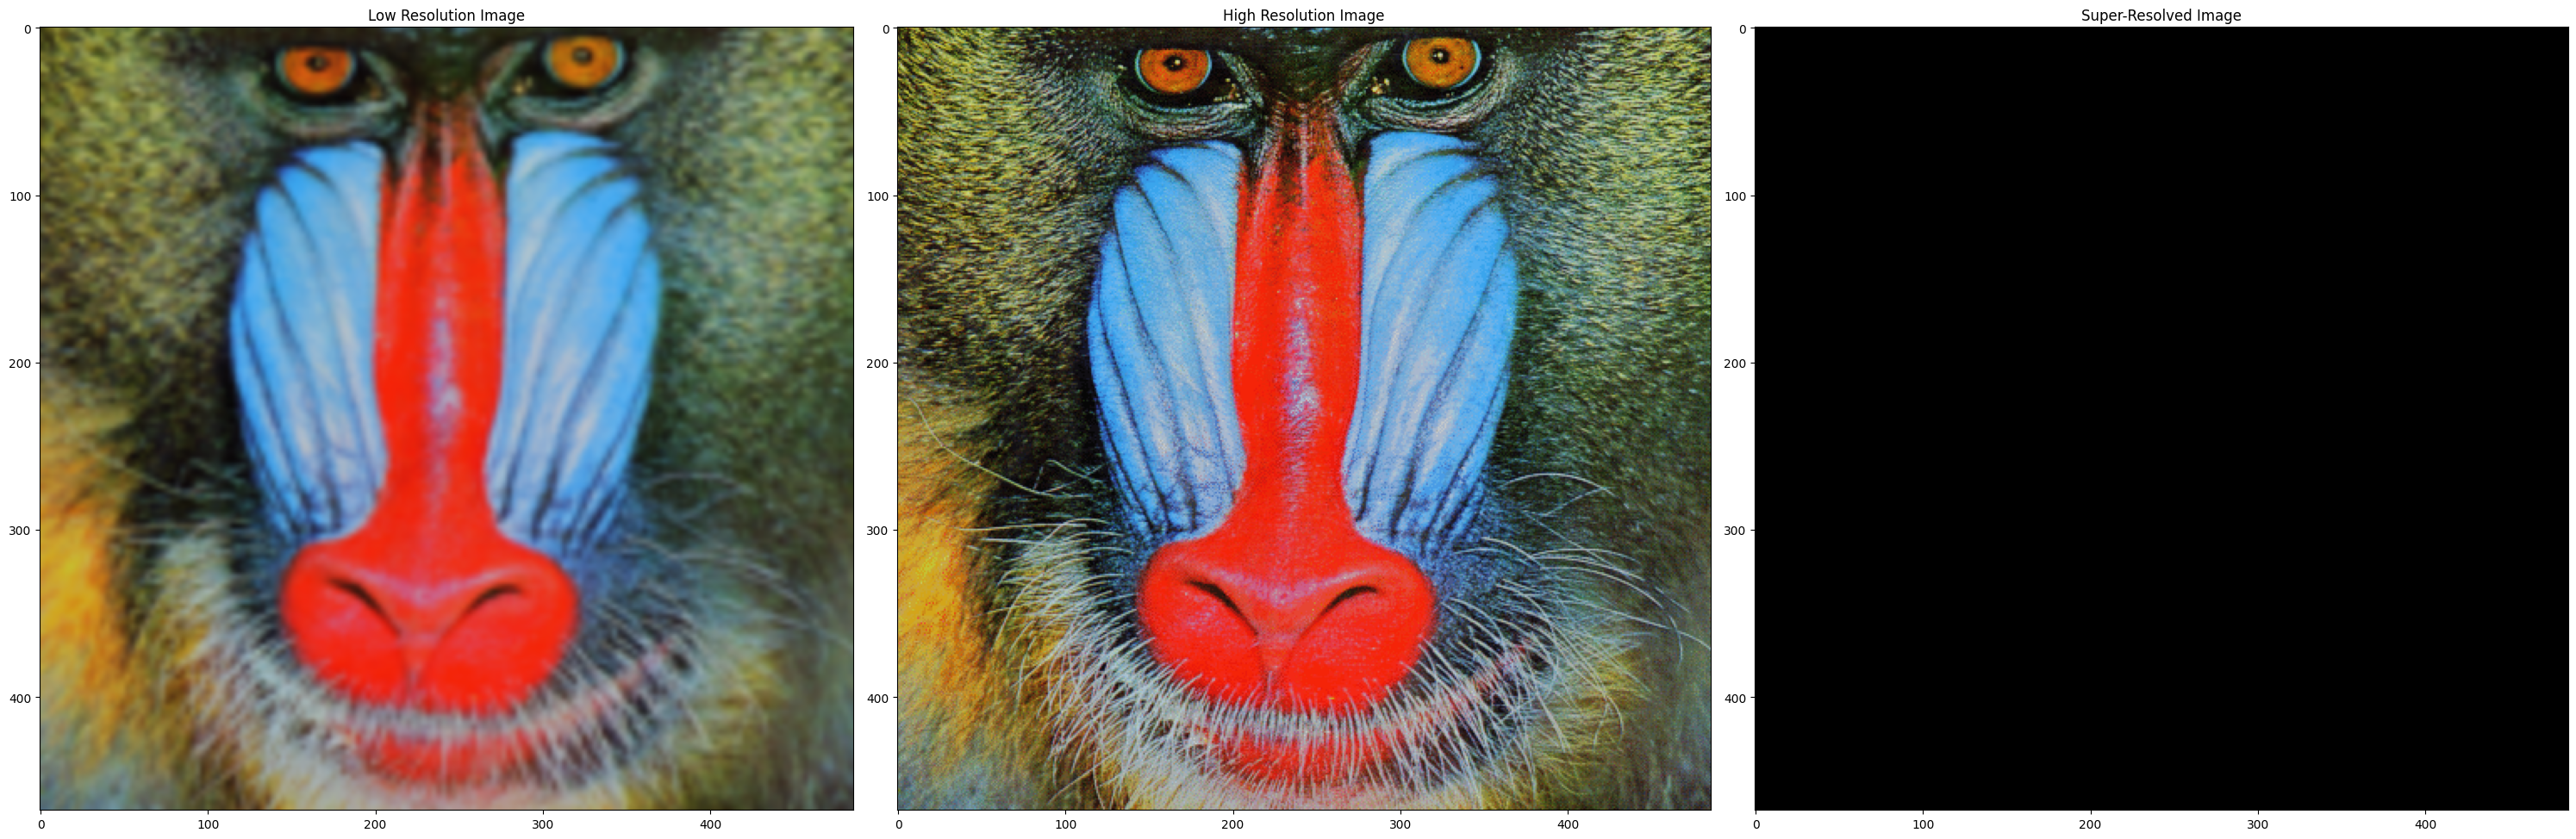

In [7]:
set14_dataset = SRCNNValidationDataset(
    img_dir=r'../data/Set14',
    scale=3,
    subset=1
)
idx = np.random.randint(0, len(set14_dataset))

sample_lr, sample_hr = set14_dataset[idx]

srcnn_9_1_5.eval()
with torch.no_grad():
    sample_lr = sample_lr.to(cuda_device).unsqueeze(0)

    sr = srcnn_9_1_5(sample_lr).squeeze(0).cpu()
    # sr = sr.clamp(0.0, 1.0).squeeze(0).cpu()

sample_lr = transforms.CenterCrop((sr.shape[1], sr.shape[2]))(sample_lr).squeeze(0).cpu()
sample_hr = transforms.CenterCrop((sr.shape[1], sr.shape[2]))(sample_hr).squeeze(0).cpu()

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow(sample_hr.permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')
axes[2].imshow(sr.permute(1, 2, 0).cpu().numpy())
axes[2].set_title('Super-Resolved Image')

plt.tight_layout()
plt.show()